In [1068]:
import pandas as pd
from pandas.io.json import json_normalize

import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

### Reading Data From Binance
🔗 Source: https://binance-docs.github.io/apidocs/spot/en/#kline-candlestick-data

Getting M5 and M1 to DataFrame

In [1069]:
url_binance_bnbusdt_5m = "https://api.binance.com/api/v3/klines?symbol=BNBUSDT&limit=1000&interval=5m"
df_binance_bnbusdt_5m = pd.read_json(url_binance_bnbusdt_5m)

df_binance_bnbusdt_5m.columns = [
    '5m_open_time', 
    '5m_open_price', 
    '5m_high_price', 
    '5m_low_price', 
    '5m_close_price', 
    '5m_volume', 
    '5m_close_time', 
    '5m_quote_asset_volume', 
    '5m_number_of_trades', 
    '5m_taker_buy_base_asset_volume', 
    '5m_taker_buy_quote_asset_volume', 
    '5m_unused'
]

df_binance_bnbusdt_5m.head()

5m_open_time  5m_open_price  5m_high_price  5m_low_price  5m_close_price  \
0  1665332400000          278.8          279.1         278.7           279.1   
1  1665332700000          279.0          279.2         279.0           279.1   
2  1665333000000          279.2          279.3         279.1           279.1   
3  1665333300000          279.2          279.2         279.0           279.0   
4  1665333600000          279.0          279.1         278.8           279.0   

   5m_volume  5m_close_time  5m_quote_asset_volume  5m_number_of_trades  \
0    922.059  1665332699999            257144.3553                  359   
1    333.257  1665332999999             93008.2371                  267   
2    463.957  1665333299999            129517.8991                  359   
3    369.855  1665333599999            103218.7697                  289   
4    270.940  1665333899999             75562.7557                  269   

   5m_taker_buy_base_asset_volume  5m_taker_buy_quote_asset_volume  5m_unused  
0                         726.410                      202601.0487          0  
1                         140.578                       39237.4256          0  
2                         191.902                       53579.0849          0  
3                          87.313                       24370.4534          0  
4                         158.768                       44282.5810          0

In [1070]:
url_binance_bnbusdt_1m = "https://api.binance.com/api/v3/klines?symbol=BNBUSDT&limit=1000&interval=1m"
df_binance_bnbusdt_1m = pd.read_json(url_binance_bnbusdt_1m)

df_binance_bnbusdt_1m.columns = [
    '1m_open_time', 
    '1m_open_price', 
    '1m_high_price', 
    '1m_low_price', 
    '1m_close_price', 
    '1m_volume', 
    '1m_close_time', 
    '1m_quote_asset_volume', 
    '1m_number_of_trades', 
    '1m_taker_buy_base_asset_volume', 
    '1m_taker_buy_quote_asset_volume', 
    '1m_unused'
]

df_binance_bnbusdt_1m.head()

1m_open_time  1m_open_price  1m_high_price  1m_low_price  1m_close_price  \
0  1665572280000          271.9          272.0         271.9           271.9   
1  1665572340000          271.9          272.0         271.9           272.0   
2  1665572400000          271.9          272.1         271.9           271.9   
3  1665572460000          272.0          272.0         271.9           272.0   
4  1665572520000          272.0          272.0         271.9           272.0   

   1m_volume  1m_close_time  1m_quote_asset_volume  1m_number_of_trades  \
0     79.258  1665572339999             21555.0039                   81   
1     73.201  1665572399999             19905.2052                   53   
2    463.658  1665572459999            126113.3213                  134   
3     41.910  1665572519999             11396.7652                   64   
4     47.356  1665572579999             12877.3452                   61   

   1m_taker_buy_base_asset_volume  1m_taker_buy_quote_asset_volume  1m_unused  
0                          47.537                       12930.0640          0  
1                          18.533                        5040.9760          0  
2                         187.745                       51067.7881          0  
3                          14.362                        3906.4640          0  
4                          12.488                        3396.7360          0

In [1071]:
len(df_binance_bnbusdt_5m), len(df_binance_bnbusdt_1m)

(1000, 1000)

### Reading Rounds Data from Pancake Subgraph
🔗 Source: https://api.thegraph.com/subgraphs/name/pancakeswap/prediction-v2

Method: `POST`

Query:

{ query: "{ rounds(first: 1000 where: {position_not: null} orderBy: epoch,orderDirection:desc) {
    id
    epoch
    position
    failed
    startAt
    startBlock
    startHash
    lockAt
    lockBlock
    lockHash
    lockPrice
    lockRoundId
    closeAt
    closeBlock
    closeHash
    closePrice
    closeRoundId
    totalBets
    totalAmount
    bullBets
    bullAmount
    bearBets
    bearAmount
    }
}", }

In [1072]:
pancake_subgraph_url = 'https://api.thegraph.com/subgraphs/name/pancakeswap/prediction-v2'
pancake_rounds_query = '{"query": "{ rounds(first: 1000 where: {position_not: null} orderBy: epoch,orderDirection:desc) { id epoch position failed startAt startBlock startHash lockAt lockBlock lockHash lockPrice lockRoundId closeAt closeBlock closeHash closePrice closeRoundId totalBets totalAmount bullBets bullAmount bearBets bearAmount } }"}'

In [1073]:
import requests
req_pancake_rounds = requests.post(url=pancake_subgraph_url, data=pancake_rounds_query)

In [1074]:
req_pancake_rounds

<Response [200]>

In [1075]:
json_pancake_rounds = req_pancake_rounds.json()

In [1076]:
len(json_pancake_rounds["data"]["rounds"])

1000

In [1077]:
df_pancake_rounds = pd.DataFrame.from_dict(json_pancake_rounds["data"]["rounds"])

In [1078]:
df_pancake_rounds.head()

id   epoch position  failed     startAt startBlock  \
0  111585  111585    House   False  1665631596   22129139   
1  111584  111584     Bear   False  1665631287   22129036   
2  111583  111583     Bull   False  1665630978   22128933   
3  111580  111580     Bear   False  1665591675   22116115   
4  111579  111579     Bear   False  1665591369   22116013   

                                           startHash      lockAt lockBlock  \
0  0x5542b350ec6587e78a78a6b8be741e723e00e72819d7...  1665631902  22129241   
1  0x4a208cf09a64c1bc55c20610a0a2a0c8805c59749190...  1665631596  22129139   
2  0xbafd3038a43c6b675d1056bf090ea7c61780ce8a6879...  1665631287  22129036   
3  0x6fab753d5945f304cde59f21b2c177984ce466421ddd...  1665591984  22116218   
4  0x165cf484346443483bf613d31203c150f312471765b8...  1665591675  22116115   

                                            lockHash  ... closeBlock  \
0  0xd66651cba4a6cd319914f815364166ff84ae7ff6f38e...  ...   22129344   
1  0x5542b350ec6587e78a78a6b8be741e723e00e72819d7...  ...   22129241   
2  0x4a208cf09a64c1bc55c20610a0a2a0c8805c59749190...  ...   22129139   
3  0xb6f9d26f4bffcc056640562f2fd54cf84edea912c010...  ...   22116321   
4  0x6fab753d5945f304cde59f21b2c177984ce466421ddd...  ...   22116218   

                                           closeHash    closePrice  \
0  0x2274b6badbd477fea5ed62abfba2e27b72fbc167127f...        270.05   
1  0xd66651cba4a6cd319914f815364166ff84ae7ff6f38e...        270.05   
2  0x5542b350ec6587e78a78a6b8be741e723e00e72819d7...  270.12563211   
3  0x0a8071cc6ee1bc563b1d7d9f4a312c6fe4619145be80...        270.24   
4  0xb6f9d26f4bffcc056640562f2fd54cf84edea912c010...        270.29   

           closeRoundId totalBets            totalAmount bullBets  \
0  18446744073711494305        41   5.506445916081445851       18   
1  18446744073711494290        33   5.873583050972632352       22   
2  18446744073711494275         6   1.295921214847330788        6   
3  18446744073711492435       103  29.111333709407959689       46   
4  18446744073711492421       109  30.388258679065375692       48   

              bullAmount bearBets             bearAmount  
0   2.819834905386526454       23   2.686611010694919397  
1   3.658771826896811438       11   2.214811224075820914  
2   1.295921214847330788        0                      0  
3  16.374583608906021076       57  12.736750100501938613  
4   9.372920177241866685       61  21.015338501823509007  

[5 rows x 23 columns]

In [1079]:
# Create a key-column to join DataFrames
df_binance_bnbusdt_5m["timestamp_key"] = pd.to_datetime(df_binance_bnbusdt_5m["5m_close_time"], unit='ms')
df_binance_bnbusdt_1m["timestamp_key"] = pd.to_datetime(df_binance_bnbusdt_1m["1m_close_time"], unit='ms')
df_pancake_rounds["timestamp_key"] = pd.to_datetime(df_pancake_rounds["closeAt"], unit='s')

# Sort by join key
df_binance_bnbusdt_5m.sort_values('timestamp_key', inplace=True)
df_binance_bnbusdt_1m.sort_values('timestamp_key', inplace=True)
df_pancake_rounds.sort_values('timestamp_key', inplace=True)

In [1080]:
# Join Dataframes
df_joined = pd.merge_asof(df_binance_bnbusdt_5m, df_pancake_rounds, on='timestamp_key',direction = 'nearest', tolerance=pd.Timedelta("5 min"))

# Remove Empty epoch column records
df_joined.dropna(subset=['epoch'], inplace=True)

df_joined.head()

5m_open_time  5m_open_price  5m_high_price  5m_low_price  5m_close_price  \
0  1665332400000          278.8          279.1         278.7           279.1   
1  1665332700000          279.0          279.2         279.0           279.1   
2  1665333000000          279.2          279.3         279.1           279.1   
3  1665333300000          279.2          279.2         279.0           279.0   
4  1665333600000          279.0          279.1         278.8           279.0   

   5m_volume  5m_close_time  5m_quote_asset_volume  5m_number_of_trades  \
0    922.059  1665332699999            257144.3553                  359   
1    333.257  1665332999999             93008.2371                  267   
2    463.957  1665333299999            129517.8991                  359   
3    369.855  1665333599999            103218.7697                  289   
4    270.940  1665333899999             75562.7557                  269   

   5m_taker_buy_base_asset_volume  ...  closeBlock  \
0                         726.410  ...    22031180   
1                         140.578  ...    22031282   
2                         191.902  ...    22031385   
3                          87.313  ...    22031488   
4                         158.768  ...    22031591   

                                           closeHash    closePrice  \
0  0x59d12c2a61aa624b67d835884d0f493267cfaae98977...        278.76   
1  0xaad8c8f42ef9e3f5df8c7b889c0aea4dea00963d302e...        279.04   
2  0xb36f95c7ec938d5db2244287ea5e0b77ecaf04b87abf...  279.10458597   
3  0x1c905c23f972b1d0a66490df9d64300af69de4b6ba1e...        279.08   
4  0x85a02abd70465a619c17c82bfc61d64c86570bf0e885...        278.89   

           closeRoundId totalBets            totalAmount bullBets  \
0  18446744073711480348       110  28.196107280540088898       59   
1  18446744073711480363        93  23.887292831390549999       46   
2  18446744073711480378        83  15.136757766813793356       47   
3  18446744073711480393        92  18.720417193146964039       46   
4  18446744073711480407        94   26.06812102986969452       47   

              bullAmount bearBets             bearAmount  
0  18.443520726217345512       51   9.752586554322743386  
1  16.194780437374191026       47   7.692512394016358973  
2    9.96000957064832393       36   5.176748196165469426  
3   6.830576209935716845       46  11.889840983211247194  
4   7.637833138778254552       47  18.430287891091439968  

[5 rows x 36 columns]

In [1081]:
df_distinct = df_joined.drop_duplicates(['epoch'], keep='last')
df_distinct.head()

5m_open_time  5m_open_price  5m_high_price  5m_low_price  5m_close_price  \
0  1665332400000          278.8          279.1         278.7           279.1   
1  1665332700000          279.0          279.2         279.0           279.1   
2  1665333000000          279.2          279.3         279.1           279.1   
3  1665333300000          279.2          279.2         279.0           279.0   
4  1665333600000          279.0          279.1         278.8           279.0   

   5m_volume  5m_close_time  5m_quote_asset_volume  5m_number_of_trades  \
0    922.059  1665332699999            257144.3553                  359   
1    333.257  1665332999999             93008.2371                  267   
2    463.957  1665333299999            129517.8991                  359   
3    369.855  1665333599999            103218.7697                  289   
4    270.940  1665333899999             75562.7557                  269   

   5m_taker_buy_base_asset_volume  ...  closeBlock  \
0                         726.410  ...    22031180   
1                         140.578  ...    22031282   
2                         191.902  ...    22031385   
3                          87.313  ...    22031488   
4                         158.768  ...    22031591   

                                           closeHash    closePrice  \
0  0x59d12c2a61aa624b67d835884d0f493267cfaae98977...        278.76   
1  0xaad8c8f42ef9e3f5df8c7b889c0aea4dea00963d302e...        279.04   
2  0xb36f95c7ec938d5db2244287ea5e0b77ecaf04b87abf...  279.10458597   
3  0x1c905c23f972b1d0a66490df9d64300af69de4b6ba1e...        279.08   
4  0x85a02abd70465a619c17c82bfc61d64c86570bf0e885...        278.89   

           closeRoundId totalBets            totalAmount bullBets  \
0  18446744073711480348       110  28.196107280540088898       59   
1  18446744073711480363        93  23.887292831390549999       46   
2  18446744073711480378        83  15.136757766813793356       47   
3  18446744073711480393        92  18.720417193146964039       46   
4  18446744073711480407        94   26.06812102986969452       47   

              bullAmount bearBets             bearAmount  
0  18.443520726217345512       51   9.752586554322743386  
1  16.194780437374191026       47   7.692512394016358973  
2    9.96000957064832393       36   5.176748196165469426  
3   6.830576209935716845       46  11.889840983211247194  
4   7.637833138778254552       47  18.430287891091439968  

[5 rows x 36 columns]

In [1082]:
# Exporting Data Frame
df_distinct.to_csv("dataset-to-predict.csv", index=False)

In [1083]:
# Remove unused columns
df_predict = df_distinct.drop([
    '5m_open_time', 
    '5m_close_time', 
    '5m_unused', 
    'timestamp_key', 
    'id', 
    'epoch', 
    'failed', 
    'startAt', 
    'startBlock', 
    'startHash', 
    'lockAt', 
    'lockBlock', 
    'lockHash', 
    'lockRoundId', 
    'closeAt', 
    'closeBlock', 
    'closeHash', 
    'closeRoundId'], axis=1)


df_predict.head()

5m_open_price  5m_high_price  5m_low_price  5m_close_price  5m_volume  \
0          278.8          279.1         278.7           279.1    922.059   
1          279.0          279.2         279.0           279.1    333.257   
2          279.2          279.3         279.1           279.1    463.957   
3          279.2          279.2         279.0           279.0    369.855   
4          279.0          279.1         278.8           279.0    270.940   

   5m_quote_asset_volume  5m_number_of_trades  5m_taker_buy_base_asset_volume  \
0            257144.3553                  359                         726.410   
1             93008.2371                  267                         140.578   
2            129517.8991                  359                         191.902   
3            103218.7697                  289                          87.313   
4             75562.7557                  269                         158.768   

   5m_taker_buy_quote_asset_volume position     lockPrice    closePrice  \
0                      202601.0487     Bull  278.57771306        278.76   
1                       39237.4256     Bull        278.76        279.04   
2                       53579.0849     Bull        279.04  279.10458597   
3                       24370.4534     Bear  279.10458597        279.08   
4                       44282.5810     Bear        279.08        278.89   

  totalBets            totalAmount bullBets             bullAmount bearBets  \
0       110  28.196107280540088898       59  18.443520726217345512       51   
1        93  23.887292831390549999       46  16.194780437374191026       47   
2        83  15.136757766813793356       47    9.96000957064832393       36   
3        92  18.720417193146964039       46   6.830576209935716845       46   
4        94   26.06812102986969452       47   7.637833138778254552       47   

              bearAmount  
0   9.752586554322743386  
1   7.692512394016358973  
2   5.176748196165469426  
3  11.889840983211247194  
4  18.430287891091439968

In [1084]:
df_predict["lockPrice"] = pd.to_numeric(df_predict["lockPrice"])
df_predict["closePrice"] = pd.to_numeric(df_predict["closePrice"])
df_predict["totalBets"] = pd.to_numeric(df_predict["totalBets"])
df_predict["totalAmount"] = pd.to_numeric(df_predict["totalAmount"])
df_predict["bullBets"] = pd.to_numeric(df_predict["bullBets"])
df_predict["bullAmount"] = pd.to_numeric(df_predict["bullAmount"])
df_predict["bearBets"] = pd.to_numeric(df_predict["bearBets"])
df_predict["bearAmount"] = pd.to_numeric(df_predict["bearAmount"])
df_predict.head()

5m_open_price  5m_high_price  5m_low_price  5m_close_price  5m_volume  \
0          278.8          279.1         278.7           279.1    922.059   
1          279.0          279.2         279.0           279.1    333.257   
2          279.2          279.3         279.1           279.1    463.957   
3          279.2          279.2         279.0           279.0    369.855   
4          279.0          279.1         278.8           279.0    270.940   

   5m_quote_asset_volume  5m_number_of_trades  5m_taker_buy_base_asset_volume  \
0            257144.3553                  359                         726.410   
1             93008.2371                  267                         140.578   
2            129517.8991                  359                         191.902   
3            103218.7697                  289                          87.313   
4             75562.7557                  269                         158.768   

   5m_taker_buy_quote_asset_volume position   lockPrice  closePrice  \
0                      202601.0487     Bull  278.577713  278.760000   
1                       39237.4256     Bull  278.760000  279.040000   
2                       53579.0849     Bull  279.040000  279.104586   
3                       24370.4534     Bear  279.104586  279.080000   
4                       44282.5810     Bear  279.080000  278.890000   

   totalBets  totalAmount  bullBets  bullAmount  bearBets  bearAmount  
0        110    28.196107        59   18.443521        51    9.752587  
1         93    23.887293        46   16.194780        47    7.692512  
2         83    15.136758        47    9.960010        36    5.176748  
3         92    18.720417        46    6.830576        46   11.889841  
4         94    26.068121        47    7.637833        47   18.430288

In [1085]:
# Change position column to 0 or 1 column
df_predict["position_code"] = pd.Categorical(df_predict.position).codes
df_predict.drop("position", axis=1, inplace=True)

In [1086]:
# Create a column transformer
ct = make_column_transformer(
    (MinMaxScaler(), ["5m_open_price", "5m_high_price", "5m_low_price", "5m_close_price", "5m_volume", "5m_quote_asset_volume", "5m_number_of_trades", "5m_taker_buy_base_asset_volume", "5m_taker_buy_quote_asset_volume", "lockPrice", "closePrice", "totalBets", "totalAmount", "bullBets", "bullAmount", "bearBets", "bearAmount"]), # turn all values in these columns between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), [])
)

In [1087]:
# Create X & y values

# The X (independent variables) will be every column of DataFrame except charges
X_read = df_predict.drop("position_code", axis=1)

# The y (dependent or label) is charges column
y_read = df_predict["position_code"]

In [1088]:
# The position Bear or Bull is for the next, so we'll shift removing first row of y and last row for X

# Drop first row of y
y = y_read.drop(index=y_read.index[0], axis=0)

# Drop last row of X
X = X_read.drop(index=X_read.index[-1], axis=0)

In [1089]:
# Split dataset in random set to train using sklearn
# Separate 20% (0.2) for test and 80% to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1090]:
len(X_train), len(X_test), len(y_train), len(y_test)

(674, 169, 674, 169)

In [1091]:
X_train.head()

5m_open_price  5m_high_price  5m_low_price  5m_close_price  5m_volume  \
482          271.1          271.3         271.0           271.2    305.309   
809          271.5          271.6         271.3           271.3    499.199   
554          271.2          271.7         270.8           271.6   1762.406   
274          274.3          274.6         274.2           274.6    849.876   
362          272.7          273.0         272.5           272.9    687.945   

     5m_quote_asset_volume  5m_number_of_trades  \
482             82789.6797                  338   
809            135486.3629                  557   
554            478121.7886                  934   
274            233262.4555                  402   
362            187623.2880                  471   

     5m_taker_buy_base_asset_volume  5m_taker_buy_quote_asset_volume  \
482                         178.032                       48282.9350   
809                         163.170                       44293.5252   
554                         544.918                      147854.1956   
274                         416.583                      114344.3888   
362                         258.336                       70473.5376   

      lockPrice  closePrice  totalBets  totalAmount  bullBets  bullAmount  \
482  271.200000  271.130000         89    10.980895        47    7.879992   
809  271.680328  271.452285         70    11.319248        35    5.139979   
554  271.652345  271.450000         98    22.288037        44    5.960398   
274  274.290000  274.421073         92    14.460565        55    9.711131   
362  272.620000  272.784326         79    14.329595        35    8.470945   

     bearBets  bearAmount  
482        42    3.100902  
809        35    6.179269  
554        54   16.327638  
274        37    4.749434  
362        44    5.858650

In [1092]:
# Fit the column transformer to our training data
ct.fit(X_train)

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['5m_open_price', '5m_high_price',
                                  '5m_low_price', '5m_close_price', '5m_volume',
                                  '5m_quote_asset_volume',
                                  '5m_number_of_trades',
                                  '5m_taker_buy_base_asset_volume',
                                  '5m_taker_buy_quote_asset_volume',
                                  'lockPrice', 'closePrice', 'totalBets',
                                  'totalAmount', 'bullBets', 'bullAmount',
                                  'bearBets', 'bearAmount']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'), [])])

In [1093]:
# Transform training and test data with normalization (MinMaxScaler) and OneHotEncoder
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

In [1094]:
# What does our data look like now?
X_train.loc[0], X_train_normal[0]

(5m_open_price                         278.800000
 5m_high_price                         279.100000
 5m_low_price                          278.700000
 5m_close_price                        279.100000
 5m_volume                             922.059000
 5m_quote_asset_volume              257144.355300
 5m_number_of_trades                   359.000000
 5m_taker_buy_base_asset_volume        726.410000
 5m_taker_buy_quote_asset_volume    202601.048700
 lockPrice                             278.577713
 closePrice                            278.760000
 totalBets                             110.000000
 totalAmount                            28.196107
 bullBets                               59.000000
 bullAmount                             18.443521
 bearBets                               51.000000
 bearAmount                              9.752587
 Name: 0, dtype: float64,
 array([0.27027027, 0.24038462, 0.3220339 , 0.28181818, 0.01852528,
        0.0181362 , 0.03380676, 0.03640513, 0.035882  , 

In [1254]:
# Test area

In [1335]:
# Discover top result

tf.random.set_seed(42)

top_result = 100 # high number
top_result_layers = [1, 1, 1, 1, 1]
top_model = None

loop_upper_bound = 1101

rand_neuron_max = 100;

for ix in range(1, loop_upper_bound):
    
    n0 = np.random.randint(rand_neuron_max, size=1)[0]
    n1 = np.random.randint(rand_neuron_max, size=1)[0]
    n2 = np.random.randint(rand_neuron_max, size=1)[0]
    n3 = np.random.randint(rand_neuron_max, size=1)[0]
    n4 = np.random.randint(rand_neuron_max, size=1)[0]
    
    # 1. Create the model (based on insurance_model_2)
    model_a = tf.keras.Sequential([
        tf.keras.layers.Dense(n0, name="hidden_layer_1"),
        tf.keras.layers.Dense(n1, name="hidden_layer_2"),
        # tf.keras.layers.Dense(n2, name="hidden_layer_3"),
        # tf.keras.layers.Dense(n3, name="hidden_layer_4"),
        # tf.keras.layers.Dense(n4, name="hidden_layer_5"),
        tf.keras.layers.Dense(1, name="output_layer")
    ], name="model_a")

    # 2. Compile the model
    model_a.compile(loss=tf.keras.losses.mse,
                              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                              metrics=["mae"])

    # 3. Fit the model
    history_model_a = model_a.fit(X_train_normal, y_train, epochs=60, verbose=0)

    # Evaluate our insurance model trained on normalized data

    evaluate_result = model_a.evaluate(X_test_normal, y_test)
    if evaluate_result[0] < top_result:
        top_result = evaluate_result[0]
        top_result_layers = [n0, n1, n2, n3, n4]
        top_model = model_a

        print("result %f" % (top_result))
        print(top_result_layers)

        
model_a = top_model
print("===== Top Final Result %f =====" % (top_result))
print(top_result_layers)

6/6 [==============================] - 0s 733us/step - loss: 0.2516 - mae: 0.4971
result 0.251567
[85, 20, 25, 92, 17]
6/6 [==============================] - 0s 687us/step - loss: 0.2429 - mae: 0.4888
result 0.242930
[91, 22, 70, 85, 9]
6/6 [==============================] - 0s 702us/step - loss: 0.2411 - mae: 0.4838
result 0.241131
[25, 16, 53, 21, 42]
6/6 [==============================] - 0s 788us/step - loss: 0.2398 - mae: 0.4824
result 0.239812
[87, 57, 41, 22, 43]
6/6 [==============================] - 0s 719us/step - loss: 0.2392 - mae: 0.4833
result 0.239180
[65, 43, 41, 94, 45]
6/6 [==============================] - 0s 760us/step - loss: 0.2381 - mae: 0.4798
result 0.238143
[56, 92, 43, 88, 42]
6/6 [==============================] - 0s 707us/step - loss: 0.2379 - mae: 0.4797
result 0.237917
[71, 74, 20, 53, 21]
6/6 [==============================] - 0s 741us/step - loss: 0.2405 - mae: 0.4836
===== Top Final Result 0.237917 =====
[71, 74, 20, 53, 21]


In [1332]:
tf.random.set_seed(42)

# # 1. Create the model (based on insurance_model_2)
# model_a = tf.keras.Sequential([
#     tf.keras.layers.Dense(15, name="hidden_layer_1", activation=tf.keras.activations.relu),
#     tf.keras.layers.Dense(39, name="hidden_layer_2", activation=tf.keras.activations.relu),
#     tf.keras.layers.Dense(112, name="hidden_layer_3", activation=tf.keras.activations.relu),
#     tf.keras.layers.Dense(1, name="output_layer")
# ], name="model_a")

# # 2. Compile the model
# model_a.compile(loss=tf.keras.losses.mse,
#                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#                           metrics=["mae"])

# # 3. Fit the model
# history_model_a = model_a.fit(X_train_normal, y_train, epochs=20, verbose=0)

# Evaluate our insurance model trained on normalized data

evaluate_result = model_a.evaluate(X_test_normal, y_test)


6/6 [==============================] - 0s 847us/step - loss: 0.2432 - mae: 0.4868


Text(0.5, 0, 'epochs')

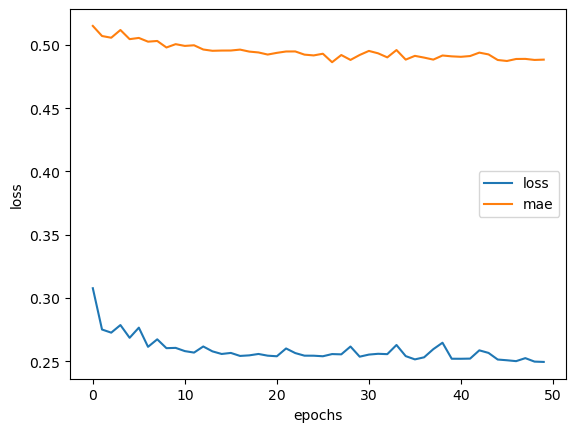

In [1333]:
# Plot history (also known as a loss curve or training curve)
pd.DataFrame(history_model_a.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

### Best result
* 100 (relu) -> 10 (relu) -> 1 (relu) -> 1 (output linear)
* Adam(learning_rate: 0.001)
* loss mse
* Epochs: 200

0.2500512897968292

In [1276]:
model_a.summary()

Model: "model_a"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 127)               2286      
                                                                 
 hidden_layer_2 (Dense)      (None, 104)               13312     
                                                                 
 hidden_layer_3 (Dense)      (None, 121)               12705     
                                                                 
 output_layer (Dense)        (None, 1)                 122       
                                                                 
Total params: 28,425
Trainable params: 28,425
Non-trainable params: 0
_________________________________________________________________


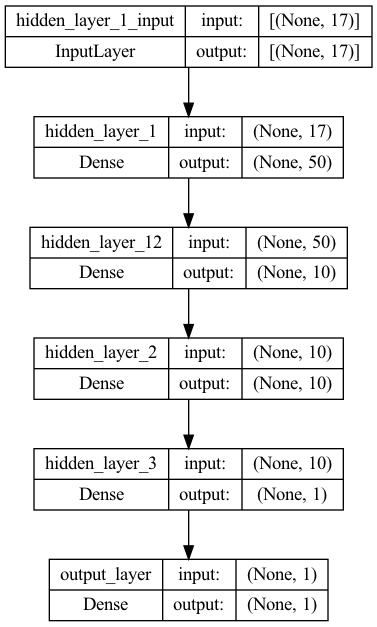

In [1142]:
plot_model(model_a, show_shapes=True)

In [1118]:
# Save model using the SavedModel format
!mkdir -p saved_model
model_a.save('saved_model/prediction_linear_regression_model_a')

INFO:tensorflow:Assets written to: saved_model/prediction_linear_regression_model_a/assets


In [1119]:
# Save model using the HDF5 format
!mkdir -p hdf5

# The '.h5' extension indicates that the model should be saved to HDF5
model_a.save('hdf5/prediction_linear_regression_model_a.h5')